In [8]:
%pip install tensorflow --quiet
%pip install scikit-learn --quiet


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.10 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [9]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
from PIL import Image, ImageOps
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [10]:
path = '/Users/anoguera/Documents/GitHub/WasteRecognition-CV'

In [12]:
def load_images_and_labels(base_dir):
    images = []
    labels = []
    class_names = os.listdir(base_dir)
    class_names.sort()  # Asegúrate de que el orden es correcto
    label_dict = {name: index for index, name in enumerate(class_names)}

    for name in class_names:
        dir_path = os.path.join(base_dir, name)
        for image_file in os.listdir(dir_path):
            if image_file.lower().endswith('.jpg'):  # Procesar solo archivos JPG
                image_path = os.path.join(dir_path, image_file)
                image = Image.open(image_path).convert("RGB")
                image = ImageOps.fit(image, (224, 224), Image.Resampling.LANCZOS)
                image_array = np.asarray(image)

                # Normalizar la imagen directamente mientras se convierte a float
                normalized_image_array = (image_array.astype(np.float32) / 127.5) - 1

                images.append(normalized_image_array)
                labels.append(label_dict[name])

    return np.array(images), np.array(labels), class_names

In [13]:
images, labels, class_names = load_images_and_labels(f'{path}/RealWaste')

In [14]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar los pesos del modelo base para no modificarlos durante el entrenamiento
for layer in base_model.layers:
    layer.trainable = False

# Añadir nuevas capas para la clasificación de basura
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(1024, activation='relu')(x)
outputs = Dense(len(class_names), activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [15]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

history = model.fit(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=8)

Epoch 1/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 141s 289ms/step - accuracy: 0.3093 - loss: 2.0407 - val_accuracy: 0.3680 - val_loss: 1.7054
Epoch 2/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 142s 298ms/step - accuracy: 0.4176 - loss: 1.6252 - val_accuracy: 0.3880 - val_loss: 1.6518
Epoch 3/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 141s 296ms/step - accuracy: 0.4048 - loss: 1.5736 - val_accuracy: 0.4374 - val_loss: 1.5731
Epoch 4/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 141s 296ms/step - accuracy: 0.4587 - loss: 1.4775 - val_accuracy: 0.4395 - val_loss: 1.5104
Epoch 5/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 145s 304ms/step - accuracy: 0.4651 - loss: 1.4279 - val_accuracy: 0.4448 - val_loss: 1.4830
Epoch 6/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 144s 302ms/step - accuracy: 0.4729 - loss: 1.3857 - val_accuracy: 0.4648 - val_loss: 1.4655
Epoch 7/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 144s 302ms/step - accuracy: 0.5031 - loss: 1.3075 - val_accuracy: 0.4627 - val_loss: 1.4756
Epoch 8/10
476/476 ━━━━━━━━━━━━━━━━━━━━ 144s 303ms/step - accuracy: 0.5300 -

In [20]:
history = model.fit(X_train, y_train, epochs=50, validation_data=(X_test, y_test), batch_size=8)

Epoch 1/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 147s 308ms/step - accuracy: 0.6131 - loss: 1.0740 - val_accuracy: 0.5100 - val_loss: 1.4313
Epoch 2/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 144s 302ms/step - accuracy: 0.6291 - loss: 1.0203 - val_accuracy: 0.5195 - val_loss: 1.3781
Epoch 3/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 144s 304ms/step - accuracy: 0.6383 - loss: 0.9988 - val_accuracy: 0.5195 - val_loss: 1.4340
Epoch 4/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 145s 304ms/step - accuracy: 0.6229 - loss: 1.0307 - val_accuracy: 0.5047 - val_loss: 1.4342
Epoch 5/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 220s 462ms/step - accuracy: 0.6790 - loss: 0.9153 - val_accuracy: 0.5436 - val_loss: 1.3992
Epoch 6/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 257s 540ms/step - accuracy: 0.6593 - loss: 0.9311 - val_accuracy: 0.5195 - val_loss: 1.4451
Epoch 7/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 260s 546ms/step - accuracy: 0.6605 - loss: 0.9628 - val_accuracy: 0.5079 - val_loss: 1.4650
Epoch 8/50
476/476 ━━━━━━━━━━━━━━━━━━━━ 250s 526ms/step - accuracy: 0.6725 -

30/30 - 22s - 740ms/step - accuracy: 0.5079 - loss: 1.4750
Test accuracy: 0.5078864097595215


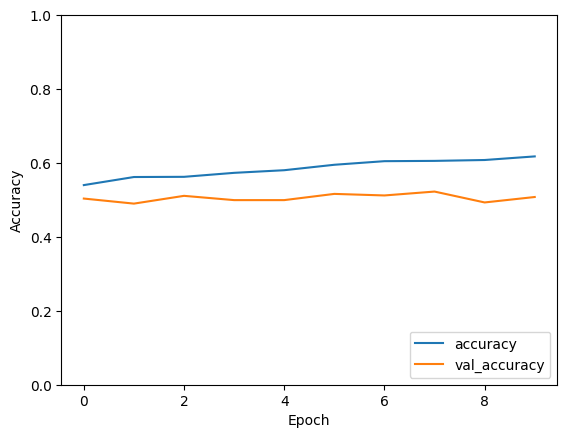

In [19]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print(f"Test accuracy: {test_acc}")

In [ ]:
X_test, y_test, class_names = load_images_and_labels(f'{path}/Test2')
